In [1]:
!export OMP_NUM_THREADS=4
!export NUMBA_NUM_THREADS=4
from mkl import set_num_threads
set_num_threads(4)

4

In [2]:
%matplotlib inline
import numpy as np
import ase
from ase.io import read
from ase.neighborlist import neighbor_list
from ase.visualize import view
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from copy import deepcopy

In [3]:
import sys
sys.path.insert(0,'../build/_deps/rascal-build/')
from rascal.utils import ostream_redirect, FPSFilter, CURFilter, dump_obj, load_obj
from rascal.representations import SphericalInvariants, SphericalExpansion
from rascal.models import Kernel

In [4]:
PATH = './'
sys.path.insert(0, '../scripts/')
from utils.io import fromfile, tofile, frompickle, topickle, _decode


# utils

In [5]:
def extract_ref(frames,info_key='energy',array_key='forces'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f

In [6]:
from utils.colormap import get_energyCmap

cmap = get_energyCmap()

from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
def plot_contour_overlay(df, x, y, values , row, col, **kwargs):
    vmin=df[values].min()
    vmax=df[values].max()
    g = sns.FacetGrid(df, col=col, row=row, height=5, dropna=False, **kwargs)
    g.map_dataframe(draw_heatmap, x, y, values, annot=True, fmt=".0f", cmap=cmap, square=True, cbar=False,
                    vmin=vmin, vmax=vmax)
    fig = g.fig
    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.93, 0.17, 0.05, 0.7])
    norm = Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label= values)
    return g
def plot_contour(df, x, y, values , row, col, **kwargs):
    vmin=df[values].min()
    vmax=df[values].max()
    g = sns.FacetGrid(df, col=col, row=row, height=5, dropna=False, **kwargs)
    g.map_dataframe(draw_heatmap, x, y, values, cmap=cmap, square=True, cbar=False,
                    vmin=vmin, vmax=vmax)
    fig = g.fig
    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.93, 0.17, 0.05, 0.7])
    norm = Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label= values)
    return g

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d = d.sort_index('index',ascending=False) 
    sns.heatmap(d, **kwargs)

## model

In [7]:
class KRR(object):
    def __init__(self, weights, kernel, X_train):
        # Weights of the krr model
        self.weights = weights
        self.kernel = kernel
        self.X_train = X_train
    def predict(self, X):
        K = self.kernel(X, self.X_train)
        return np.dot(K, self.weights).reshape((-1))
        
def train_krr(X, K_,y,kernel, sigma, jitter=1e-7):
    K = K_.copy()
    delta = np.std(y) / np.mean(K.diagonal())
    K[np.diag_indices_from(K)] += sigma**2/ delta **2 + jitter
    weights = np.linalg.solve(K,y)
    return KRR(weights, kernel, X)



In [8]:
def test_krr(train, test, K, y, sigma, jitter=1e-7):
    Kt = K[np.ix_(train,train)]
    delta = np.std(y[train]) / np.mean(Kt.diagonal())
    Kt[np.diag_indices_from(Kt)] += sigma**2/ delta **2 + jitter
    weights = np.linalg.solve(Kt,y[train])
    y_pred = np.dot(K[np.ix_(test,train)], weights)
    score = get_score(y_pred, y[test])
    return score, y_pred, y[test]

## LC

In [9]:
from scipy.stats import spearmanr

def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator/ denominator)
    return np.mean(output_scores)

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_spearman(ypred,y):
    corr,_ = spearmanr(ypred,y)
    return corr

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
    CORR=get_spearman
)

def get_score(ypred,y):
    scores = {}
    for k,func in list(score_func.items()):
        scores[k] = func(ypred,y)
    return scores

In [10]:
from sklearn.model_selection._split import ShuffleSplit, KFold
from abc import ABCMeta, abstractmethod
import collections
from sklearn.model_selection._split import (_BaseKFold,
        BaseCrossValidator,_validate_shuffle_split,BaseShuffleSplit)
from sklearn.utils.validation import _num_samples
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod

class LCSplit(object):
    def __init__(self, cv, n_repeats=[10],train_sizes=[10],test_size="default", random_state=None, **cvargs):

        self.cv = cv
        self.n_repeats = n_repeats
        self.train_sizes = train_sizes
        self.random_state = random_state
        self.cvargs = cvargs
        self.test_size = test_size
        self.n_splits = np.sum(n_repeats)
    
    def get_params(self):
        params = dict(cv=self.cv.get_params(),n_repeats=self.n_repeats,train_sizes=self.train_sizes,
                     test_size=self.test_size,random_state=self.random_state,cvargs=self.cvargs)
        return params

    def split(self, X, y=None, groups=None):
        """Generates indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, of length n_samples
            The target variable for supervised learning problems.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """

        rng = check_random_state(self.random_state)
        
        for n_repeat,train_size in zip(self.n_repeats,self.train_sizes):
            cv = self.cv(random_state=rng, n_splits=n_repeat,test_size=self.test_size,train_size=train_size,
                             **self.cvargs)
            for train_index, test_index in cv.split(X, y, groups):
                yield train_index, test_index
                
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator
        Parameters
        ----------
        X : object
            Always ignored, exists for compatibility.
            ``np.zeros(n_samples)`` may be used as a placeholder.
        y : object
            Always ignored, exists for compatibility.
            ``np.zeros(n_samples)`` may be used as a placeholder.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        rng = check_random_state(self.random_state)
        n_splits = 0
        for n_repeat,train_size in zip(self.n_repeats,self.train_sizes):
            cv = self.cv(random_state=rng, n_splits=n_repeat,test_size=self.test_size,train_size=train_size,
                             **self.cvargs)
            n_splits += cv.get_n_splits(X, y, groups)
        return n_splits
    

In [11]:
from rascal.utils.io import BaseIO
from rascal.lib import sparsification

from rascal.utils.filter_utils import (get_index_mappings_sample_per_species,
                           convert_selected_global_index2perstructure_index_per_species,
                           get_index_mappings_sample,
                           convert_selected_global_index2perstructure_index)
import numpy as np


def fps(feature_matrix, n_select, starting_index=None,
        method='simple', restart=None):
    """
    Farthest Point Sampling [1] routine using librascal.

    Parameters
    ----------
    feature_matrix : numpy.ndarray[float64[n, m], flags.c_contiguous]
        Feature matrix with n samples and m features.
    n_select : int
        Number of sample to select
    starting_index : int, optional
        Index of the first sample to select (the default is None,
                           which corresponds to starting_index == 0)
    restart : dictionary, optional (only valid for method="simple")
        the return value of a previous call to FPS. the selection
        will continue where it has been left off. the dictionary
        should contain at least "fps_indices"; if "fps_minmax_d2" and
        "fps_hausdorff_d2" are present, they will be used to restart,
        otherwise they'll be recomputed

    method : str, optional
        Select which kind of FPS selection to perform:
        + 'simple' is the basic fps selection [1].
        + 'voronoi' uses voronoi polyhedra to avoid some
                    distance computations.

    Returns
    -------
    A dictionary containing the following quantities
    "fps_indices" : numpy.ndarray[int[n_select]]
        Selected indices refering to the feature_matrix order.
    "fps_minmax_d2": numpy.ndarray[float64[n_select]]
        MIN-MAX distance^2 at each step in the selection
    "fps_hausforff_d2": numpy.ndarray[float64[n]]
        array of Hausdorff distances between the n points and the
        n_select FPS points
    In addition, when method="voronoi", the following arrays are returned
    "fps_voronoi_indices": numpy.ndarray[int[n]]
        the indices that assign each of the n inputs to the closest FPS point
    "fps_voronoi_r2": numpy.ndarray[float64[n_select]]
        the squared "Voronoi radius" of each FPS point (the largest distance to
        one of the points associated to its Voronoi cell


    .. [1] Ceriotti, M., Tribello, G. A., & Parrinello, M. (2013).
        Demonstrating the Transferability and the Descriptive Power of Sketch-Map.
        Journal of Chemical Theory and Computation, 9(3), 1521–1532.
        https://doi.org/10.1021/ct3010563
    """

    if starting_index is None:
        starting_index = 0

    return_dict = {}
    if method == 'simple':
        if restart is None:
            sparse_indices, sparse_minmax_d2, lmin_d2 = \
                sparsification.fps(feature_matrix, n_select, starting_index)
        else:
            res_tuple = (restart["fps_indices"],
                         (restart["fps_minmax_d2"] if "fps_minmax_d2" in restart
                          else np.zeros(0, float)),
                         (restart["fps_hausdorff_d2"] if "fps_hausdorff_d2" in restart
                          else np.zeros(0, float)))
            sparse_indices, sparse_minmax_d2, lmin_d2 = \
                sparsification.fps(feature_matrix, n_select,
                                   starting_index, res_tuple)

    elif method == 'voronoi':
        sparse_indices, sparse_minmax_d2, lmin_d2, \
            voronoi_indices, voronoi_r2 = \
            sparsification.fps_voronoi(feature_matrix,
                                       n_select, starting_index)
        return_dict["fps_voronoi_indices"] = voronoi_indices
        return_dict["fps_voronoi_r2"] = voronoi_r2

    else:
        raise Exception('Unknown FPS algorithm {}'.format(method))

    return_dict["fps_indices"] = sparse_indices
    return_dict["fps_minmax_d2"] = sparse_minmax_d2
    return_dict["fps_hausdorff_d2"] = lmin_d2

    return return_dict

def avg_structure(manangers,X):
    strides = [0]
    for manager in managers:
        strides.append(len(manager))
    strides = np.cumsum(strides)
    X_avg = np.zeros((len(managers),X.shape[1]))
    i_str = 0
    for st,nd in zip(strides[:-1],strides[1:]):
        X_avg[i_str] = np.mean(X[st:nd],axis=0)
    return X_avg

class FPSFilter(BaseIO):
    """Farthest Point Sampling (FPS) to select samples or features in a given feature matrix.
    Wrapper around the fps function for convenience.
    Parameters
    ----------
    representation : Calculator
        Representation calculator associated with the kernel
    Nselect: int
        number of points to select. if act_on='sample per specie' then it should
        be a dictionary mapping atom type to the number of samples, e.g.
        Nselect = {1:200,6:100,8:50}.
    act_on: string
        Select how to apply the selection. Can be either of 'sample',
        'sample per species','feature'.
    starting_index: int
        Index used to start the FPS selection with.

    """

    def __init__(self, representation, Nselect, act_on='sample per species',
                 starting_index=0, method='simple', average=False):
        self._representation = representation
        self.Nselect = Nselect
        self.starting_index = starting_index
        modes = ['sample', 'sample per species', 'feature']
        if act_on in modes:
            self.act_on = act_on
        else:
            raise ValueError(
                '"act_on" should be either of: "{}", "{}", "{}"'.format(*modes))

        # effectively selected list of indices at the filter step
        # the indices have been reordered for effiency and compatibility with
        # the c++ routines
        self.selected_ids = None
        # for 'sample' selection
        self.selected_sample_ids = None
        # for 'sample per species' selection
        self.selected_sample_ids_by_sp = None
        # for feature selection
        self.selected_feature_ids_global = None

        self.fps_minmax_d2_by_sp = None
        self.fps_minmax_d2 = None
        self.method=method
        self.fps_out = None
        self.average = average

    def select(self, managers, restart=False):
        """Perform FPS selection of samples/features.
        Parameters
        ----------
        managers : AtomsList
            list of structures containing features computed with representation
        Returns
        -------
        PseudoPoints
            Selected samples
        Raises
        ------
        ValueError
            [description]
        NotImplementedError
            [description]
        """

        # get the dense feature matrix
        X = managers.get_features(self._representation)
        
        
        if restart and self.fps_out:
            restart = self.fps_out
        else:
            restart = None
            
        if self.act_on == 'sample per species':
            sps = list(self.Nselect.keys())

            # get various info from the structures about the center atom species and indexing
            (strides_by_sp, global_counter, map_by_manager,
             indices_by_sp) = get_index_mappings_sample_per_species(managers, sps)

            print('The number of pseudo points selected by central atom species is: {}'.format(
                self.Nselect))

            # organize features w.r.t. central atom type
            X_by_sp = {}
            for sp in sps:
                X_by_sp[sp] = X[indices_by_sp[sp]]
            self._XX = X_by_sp

            # split the dense feature matrix by center species and apply CUR decomposition
            self.selected_sample_ids_by_sp = {}
            self.fps_minmax_d2_by_sp = {}
            self.fps_hausforff_d2_by_sp = {}
            for sp in sps:
                print('Selecting species: {}'.format(sp))
                fps_out = fps(X_by_sp[sp], self.Nselect[sp], method=self.method,
                              starting_index=self.starting_index, restart=restart)
                
                self.selected_sample_ids_by_sp[sp] = fps_out['fps_indices']
                self.fps_minmax_d2_by_sp[sp] = fps_out['fps_minmax_d2']

            return self
        elif self.act_on == 'feature':
            if self.average:
                X = avg_structure(manangers,X)
            fps_out = fps(X.T, self.Nselect,method=self.method,
                          starting_index=self.starting_index,restart=restart)
            self.selected_feature_ids_global = fps_out['fps_indices']
            self.fps_minmax_d2 = fps_out['fps_minmax_d2']
        elif self.act_on == 'sample':
            fps_out = fps(X, self.Nselect,method=self.method,
                          starting_index=self.starting_index,restart=restart)
            self.selected_sample_ids = fps_out['fps_indices']
            self.fps_minmax_d2 = fps_out['fps_minmax_d2']
        else:
            raise NotImplementedError("method: {}".format(self.act_on))
        self.fps_out = fps_out

    def filter(self, managers, n_select=None):
        from rascal.models import SparsePoints
        if n_select is None:
            n_select = self.Nselect

        if self.act_on == 'sample per species':
            sps = list(n_select.keys())
            # get various info from the structures about the center atom species and indexing
            (strides_by_sp, global_counter, map_by_manager,
             indices_by_sp) = get_index_mappings_sample_per_species(managers, sps)
            selected_ids_by_sp = {key: np.sort(val[:n_select[key]])
                                  for key, val in self.selected_sample_ids_by_sp.items()}
            self.selected_ids = convert_selected_global_index2perstructure_index_per_species(
                managers, selected_ids_by_sp, strides_by_sp, map_by_manager, sps)
            # return self.selected_ids
            # build the pseudo points
            pseudo_points = SparsePoints(self._representation)
            pseudo_points.extend(managers, self.selected_ids)
            return pseudo_points

        elif self.act_on == 'sample':
            selected_ids_global = np.sort(self.selected_sample_ids[:n_select])
            strides, _, map_by_manager = get_index_mappings_sample(managers)
            self.selected_ids = convert_selected_global_index2perstructure_index(managers,
                                                                            selected_ids_global, strides, map_by_manager)
            return self.selected_ids
            # SparsePoints is not compatible with a non center atom species
            # dependant sparse points
            # # build the pseudo points
            # pseudo_points = SparsePoints(self._representation)
            # pseudo_points.extend(managers, self.selected_ids)
            # return pseudo_points

        elif self.act_on == 'feature':
            feat_idx2coeff_idx = self._representation.get_feature_index_mapping(
                managers)
            self.selected_ids = {key: []
                                 for key in feat_idx2coeff_idx[0].keys()}
            selected_ids_sorting = np.argsort(
                self.selected_feature_ids_global[:n_select])
            selected_feature_ids = self.selected_feature_ids_global[selected_ids_sorting]
            for idx in selected_feature_ids:
                coef_idx = feat_idx2coeff_idx[idx]
                for key in self.selected_ids.keys():
                    self.selected_ids[key].append(int(coef_idx[key]))
            # keep the global indices and ordering for ease of use
            self.selected_ids['selected_features_global_ids'] = selected_feature_ids.tolist(
            )
            self.selected_ids['selected_features_global_ids_fps_ordering'] = selected_ids_sorting.tolist(
            )
            self.selected_ids = dict(coefficient_subselection=self.selected_ids)
            return self.selected_ids

    def select_and_filter(self, managers):
        return self.select(managers).filter(managers)

    def plot_fps_error(self):
        import matplotlib.pyplot as plt
        if self.fps_minmax_d2_by_sp is None:
            plt.semilogy(self.fps_minmax_d2, label=self.act_on)

        else:
            for sp in self.fps_minmax_d2_by_sp:
                plt.semilogy(self.fps_minmax_d2_by_sp[sp],
                             label='{} species {}'.format(self.act_on, sp))
            plt.legend()
        plt.title('FPSFilter')
        plt.ylabel('fps minmax d^2')

    def _get_data(self):
        return dict(selected_ids=self.selected_ids,
                    selected_sample_ids=self.selected_sample_ids,
                    selected_sample_ids_by_sp=self.selected_sample_ids_by_sp,
                    selected_feature_ids_global=self.selected_feature_ids_global)

    def _set_data(self, data):
        self.selected_ids = data['selected_ids']
        self.selected_sample_ids = data['selected_sample_ids']
        self.selected_sample_ids_by_sp = data['selected_sample_ids_by_sp']
        self.selected_feature_ids_global = data['selected_feature_ids_global']

    def _get_init_params(self):
        return dict(representation=self._representation,
                    Nselect=self.Nselect,
                    act_on=self.act_on,
                    starting_index=self.starting_index,)


# soap

In [12]:
frames = read('mebox-minimal-pbe0-b1b.xyz',':')
frames.extend(read('mebox-minimal-oos-T110-pbe0-b1b.xyz',':'))
frames.extend(read('mebox-minimal-oos-T188-pbe0-b1b.xyz',':'))
y,f = extract_ref(frames,info_key='energy',array_key='force')
global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
    frame.wrap(eps=1e-11)
n_sp = np.bincount(global_species)
global_species = np.unique(global_species)
natoms = np.zeros(len(frames))
for iframe,frame in enumerate(frames):
    natoms[iframe] = len(frame)
    
tot = n_sp.sum()
sparse_proportions = {sp:n_sp[sp]/tot for sp in global_species}

n_sp, global_species,sparse_proportions,len(frames)

(array([    0, 30672,     0,     0,     0,     0,  7668]),
 array([1, 6]),
 {1: 0.8, 6: 0.2},
 284)

In [13]:
rc = 5.
gs = 0.5

rep = {
    "interaction_cutoff": rc,
    "cutoff_smooth_width": 1.,
    "max_radial": 8,
    "max_angular": 6,
    "gaussian_sigma_type": "Constant",
    "soap_type": "PowerSpectrum",
    "normalize": True,
    "expansion_by_species_method": "structure wise",
    "compute_gradients": False,
    "cutoff_function_type": "ShiftedCosine",
    "gaussian_sigma_constant": gs,
    "radial_basis": "GTO",
    "optimization_args":{
      "type": "Spline", "accuracy": 1e-08, "range": [0, rc]
    },
}
soap = SphericalInvariants(**rep)


In [21]:
%%time
managers = soap.transform(frames)
# pp = managers.get_features(soap)

CPU times: user 3.64 s, sys: 583 ms, total: 4.22 s
Wall time: 4.22 s


In [22]:
global_species

array([1, 6])

In [23]:
nsp = 2
n = 8
l = 7
nn = n*nsp
l*nn*(nn+1)/2,l*n**2*nsp*(nsp+1)/2

(952.0, 1344.0)

In [24]:
n_sparses = [100, 200, 500, 1000, 2000, 5000, 7000, 9000]

The number of pseudo points selected by central atom species is: {1: 7200, 6: 1800}
Selecting species: 1
Selecting species: 6
CPU times: user 4min 12s, sys: 1.67 s, total: 4min 13s
Wall time: 4min 11s


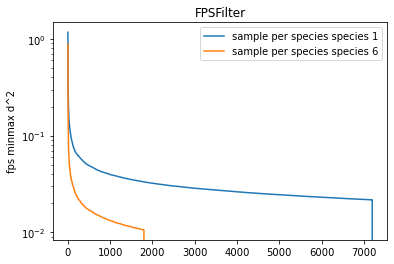

In [25]:
%%time
Nselect = {sp:int(n_sparses[-1]*f) for sp,f in sparse_proportions.items()}

compressor = FPSFilter(soap, Nselect, act_on='sample per species')

compressor.select(managers)
compressor.plot_fps_error()

In [26]:
n_features = [int(952*f) for f in [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1]]

CPU times: user 42.6 s, sys: 512 ms, total: 43.1 s
Wall time: 42.9 s


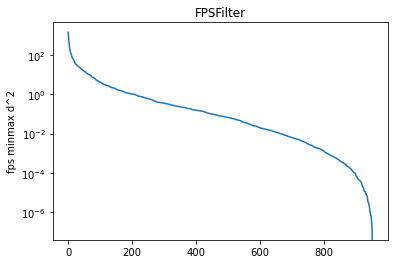

In [27]:
%%time
Nselect = n_features[-1]

fcompressor = FPSFilter(soap, Nselect, act_on='feature')
fcompressor.select(managers)

# fcompressor = FPSFilter(soap, 100, act_on='feature')
# fcompressor.select(managers)
# for n_feat in tqdm(np.array(np.arange(200,Nselect+300,400),dtype=int)):
#     fcompressor.Nselect = n_feat
#     fcompressor.select(managers,restart=True)

fcompressor.plot_fps_error()

In [28]:
fcompressor.fps_out

In [25]:
!ls -lah $PATH

total 15G
drwxrwxrwx  3 musil COSMO-StaffU   25 Sep 15 07:43 .
drwxrwxrwx 16 musil COSMO-StaffU   27 Sep 14 10:54 ..
-rw-rw-rw-  1 musil COSMO-StaffU  45K Sep 10 17:04 cv-scores-1.pck
-rw-rw-rw-  1 musil COSMO-StaffU  45K Sep 10 22:50 cv-scores-2.pck
-rw-rw-rw-  1 musil COSMO-StaffU  22K Sep 11 12:59 cv-scores-3.pck
-rw-rw-rw-  1 musil COSMO-StaffU  45K Sep 10 12:24 cv-scores.pck
-rw-r--r--  1 musil COSMO-StaffU  33M Sep  1 18:08 dft-smiles_30000.xyz
-rw-r--r--  1 musil COSMO-StaffU 235K Sep  1 18:08 dft-smiles_eV_30000.dHf_peratom.npy
-rw-rw-rw-  1 musil COSMO-StaffU  57K Sep  8 12:13 fps_features_14000.pck
-rw-rw-rw-  1 musil COSMO-StaffU  73K Sep 15 07:40 fps_features_18300.pck
-rw-rw-rw-  1 musil COSMO-StaffU  80K Sep 15 07:40 fps_samples_20000.pck
-rw-rw-rw-  1 musil COSMO-StaffU  26K Sep  3 19:36 fps_samples_6200.pck
drwxrwxrwx  2 musil COSMO-StaffU    3 Sep  1 18:11 .ipynb_checkpoints
-rw-rw-rw-  1 musil COSMO-StaffU 1.4G Sep  8 19:34 KNM_np6200_nf11200.npy
-rw-rw-rw-  1 musil C

In [28]:
topickle(PATH+'fps_features_{}.pck'.format(n_features[-1]),fcompressor)
topickle(PATH+'fps_samples_{}.pck'.format(n_sparses[-1]),compressor)

In [15]:
fcompressor = frompickle(PATH+'fps_features_952.pck')
compressor = frompickle(PATH+'fps_samples_9000.pck')

In [29]:
def get_per_sp_sparsepoints(n_sparse, sparse_proportions):
    aa = np.zeros(np.max(list(sparse_proportions))+1,dtype=int)
    for sp,f in sparse_proportions.items():
        val = int(n_sparse*f)
        if val == 0:
            val = 1
        aa[sp] = val

    v = np.sum(aa)
    if v != n_sparse:
        diff = n_sparse-v
        iaa = np.argmax(aa)
        aa[iaa] = aa[iaa]+diff

    Nselect = {sp:aa[sp] for sp,f in sparse_proportions.items()}
    return Nselect

In [30]:
hypers = deepcopy(rep)
for n_feature in  tqdm(n_features):
    sel = fcompressor.filter(managers, n_feature)
    hypers.update(**sel)
    fsoap = SphericalInvariants(**hypers)
    fmanagers = fsoap.transform(frames)
    compressor._representation = fsoap
    for n_sparse in tqdm(n_sparses,leave=False):
        Nselect = get_per_sp_sparsepoints(n_sparse, sparse_proportions)
        X_sparse = compressor.filter(fmanagers, Nselect)
        print(X_sparse.size(), n_sparse)
        dump_obj('./sparse_points_np{}_nf{}.json'.format(n_sparse,n_feature), X_sparse)

100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000


100 100
200 200
500 500
1000 1000
2000 2000
5000 5000
7000 7000
9000 9000



In [31]:
zeta = 4

In [32]:
Nstructures = len(frames)
Ngrad_stride = [0]
Ngrads = 0
for frame in frames:
    n_at = len(frame)
    Ngrad_stride.append(n_at*3)
    Ngrads += n_at*3
Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures

In [34]:
from concurrent.futures import as_completed, ProcessPoolExecutor
def init_proc(n_feature, n_sparse, zeta):
    global X_pseudo
    global soap
    global kernel
    X_pseudo = load_obj('sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    
def compute(i_frame,frame):   
    feat = soap.transform([frame])
    en_row = kernel(feat, X_pseudo)
    grad_rows = kernel(feat, X_pseudo, grad=(True, False))
    grad_rows = None
    return en_row, grad_rows


Nstructures  = len(frames)
ii = 0
for n_feature in tqdm(n_features):
    for n_sparse in tqdm(n_sparses):
        with ProcessPoolExecutor(max_workers=10, initializer=init_proc, 
                                 initargs=(n_feature, n_sparse, zeta)) as executor:
            print(n_feature, n_sparse)
            KNM = np.zeros((Nstructures+Ngrads, n_sparse))
            KNM = np.zeros((Nstructures, n_sparse))

            future_to_compute = {executor.submit(compute, i_frame, frame):i_frame
                                                         for i_frame,frame in enumerate(frames)}
            pbar = tqdm(total=len(future_to_compute))
            for future in as_completed(future_to_compute):
                i_frame = future_to_compute[future]
                en_row, grad_rows = future.result()
                KNM[i_frame] = en_row
                KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
                pbar.update()
            np.save('KNM_z{}_np{}_nf{}.npy'.format(zeta, n_sparse, n_feature), KNM)

9 100


9 200


9 500


9 1000


9 2000


9 5000


9 7000


9 9000


19 100


19 200


19 500


19 1000


19 2000


19 5000


19 7000


19 9000


47 100


47 200


47 500


47 1000


47 2000


47 5000


47 7000


47 9000


95 100


95 200


95 500


95 1000


95 2000


95 5000


95 7000


95 9000


190 100


190 200


190 500


190 1000


190 2000


190 5000


190 7000


190 9000


285 100


285 200


285 500


285 1000


285 2000


285 5000


285 7000


285 9000


476 100


476 200


476 500


476 1000


476 2000


476 5000


476 7000


476 9000


666 100


666 200


666 500


666 1000


666 2000


666 5000


666 7000


666 9000


761 100


761 200


761 500


761 1000


761 2000


761 5000


761 7000


761 9000


856 100


856 200


856 500


856 1000


856 2000


856 5000


856 7000


856 9000


952 100


952 200


952 500


952 1000


952 2000


952 5000


952 7000


952 9000


In [32]:
X_pseudo = load_obj('sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
X_pseudo.size()

98

# get optimal hyper and LC

In [12]:
from rascal.utils import BaseIO
from concurrent.futures import as_completed, ProcessPoolExecutor

class KRR(BaseIO):
    """Kernel Ridge Regression model. Only compatible fully with sparse GPR
    training for the moment.

    Parameters
    ----------
    weights : np.array
        weights of the model

    kernel : Kernel
        kernel class used to train the model

    X_train : PseudoPoints
        reference samples used for the training

    self_contributions : dictionary
        map atomic number to the property baseline, e.g. isolated atoms
        energies when the model has been trained on total energies.
    """

    def __init__(self, weights, kernel, X_train, self_contributions):
        super(KRR, self).__init__()
        # Weights of the krr model
        self.weights = weights
        self.kernel = kernel
        self.X_train = X_train
        self.self_contributions = self_contributions
        self.target_type = kernel.target_type

    def _get_property_baseline(self, managers):
        """build total baseline contribution for each prediction"""
        if self.target_type == 'Structure':
            Y0 = np.zeros(len(managers))
            for i_manager, manager in enumerate(managers):
                if isinstance(manager, ase.Atoms):
                    numbers = manager.get_atomic_numbers()
                    for sp in numbers:
                        Y0[i_manager] += self.self_contributions[sp]
                else:
                    for at in manager:
                        Y0[i_manager] += self.self_contributions[at.atom_type]
        elif self.target_type == 'Atom':
            n_centers = 0
            for manager in managers:
                n_centers += len(manager)
            Y0 = np.zeros(n_centers)
            i_center = 0
            for manager in managers:
                for sp in manager.get_atomic_numbers():
                    Y0[i_center] = self.self_contributions[sp]
                    i_center += 1
        return Y0

    def _preprocess_input(self, managers, KNM, compute_gradients=False, compute_stress=False):
        """compute prediction kernel and total baseline contributions"""
        from rascal.utils.io import is_npy

        if KNM is not None: # if the KNM matrix is provided
            kernel = KNM
        else: # if the representation is provided
            kernel = self.kernel(managers, self.X_train, (compute_gradients, False),)
        Y0 = self._get_property_baseline(managers)
        return kernel, Y0

    def predict(self, managers, KNM=None, compute_gradients=False, compute_stress=False):
        """Predict properties associated with the atomic structures in managers
        or their derivative w.r.t. atomic positions (if compute_gradients==True).

        Parameters
        ----------
        managers : AtomsList
            list of atomic structures with already computed features compatible
            with representation in kernel
        compute_gradients : bool, optional
            predict the gradients of the property w.r.t atomic positions,
            by default False

        Returns
        -------
        np.array
            predictions
        """
        KNM, Y0 = self._preprocess_input(managers, KNM, compute_gradients, compute_stress)
        if compute_gradients is False:
            return Y0 + np.dot(KNM, self.weights).reshape(-1)
        else:
            aa = np.dot(KNM, self.weights)
            return np.dot(KNM, self.weights)

    def get_weigths(self):
        return self.weights

    def _get_init_params(self):
        init_params = dict(weights=self.weights, kernel=self.kernel,
                           X_train=self.X_train, self_contributions=self.self_contributions)
        return init_params

    def _set_data(self, data):
        pass

    def _get_data(self):
        return dict()

def train_gap_model_0(kernel, frames, KNM_, X_pseudo, y_train, self_contributions, grad_train=None, 
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    Y = y_train.reshape((-1, 1)).copy()
    KNM = KNM_.copy()
    n_centers = Y.shape[0]
    Natoms = np.zeros(n_centers)
    Y0 = np.zeros((n_centers, 1))
    for iframe, frame in enumerate(frames):
        Natoms[iframe] = len(frame)
        numbers = frame.get_atomic_numbers()
        for sp in numbers:
            Y0[iframe] += self_contributions[sp]
    Y = Y - Y0
    delta = np.std(Y)
    # print(delta)
    # lambdas[0] is provided per atom hence the '* np.sqrt(Natoms)'
    # the first n_centers rows of KNM are expected to refer to the
    # property
#     print(Natoms)
    KNM[:n_centers] /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]
    Y /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]

    if grad_train is not None:
        KNM[n_centers:] /= lambdas[1] / delta
        F = grad_train.reshape((-1, 1)).copy()
        F /= lambdas[1] / delta
        Y = np.vstack([Y, F])
    
    K = KMM + np.dot(KNM.T, KNM)
    eig,_ = np.linalg.eig(K)
    if eig.min() < 0:
        jitter = 1.05*abs(eig.min())
    
    # print('jitter ',jitter, eig.min())
    K[np.diag_indices_from(K)] += jitter
    
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
#     weights,_,_,_ = np.linalg.lstsq(K, Y, rcond=None)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model

def extract_ref(frames,info_key='energy',array_key='force'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f

def get_strides(frames):
    Nstructures = len(frames)
    Ngrad_stride = [0]
    Ngrads = 0
    for frame in frames:
        n_at = len(frame)
        Ngrad_stride.append(n_at*3)
        Ngrads += n_at*3
    Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures
    return Nstructures,Ngrads,Ngrad_stride

def get_grad_strides(frames):
    Nstructures = len(frames)
    Ngrad_stride = [0]
    Ngrads = 0
    n_atoms = []
    for frame in frames:
        n_at = len(frame)
        n_atoms.append(n_at)
        Ngrad_stride.append(n_at*3)
        Ngrads += n_at*3
    Ngrad_stride = np.cumsum(Ngrad_stride)
    return np.array(n_atoms).reshape((-1,1)),Ngrad_stride


def _split_KNM(ids, frames, KNM, grad_strides):
    Nstruct, Ngrad, _ = get_strides(frames)
    KNM_ = np.zeros((Nstruct+Ngrad, KNM.shape[1]))
    i_struct,i_grad = 0, Nstruct
    for idx in ids:
        KNM_[i_struct] = KNM[idx]
        kk = KNM[grad_strides[idx]:grad_strides[idx+1]]
        KNM_[i_grad:i_grad+kk.shape[0]] = kk
        i_struct += 1
        i_grad += kk.shape[0]
    return KNM_

# def split_data(frames,KNM,f,seed=10):
#     Nstruct, Ngrad, grad_strides = get_strides(frames)
#     ids = list(range(Nstruct))
#     np.random.seed(seed)
#     np.random.shuffle(ids)
    
#     frames_train = [frames[ii] for ii in ids[:int(f*Nstruct)]]
#     frames_test = [frames[ii] for ii in ids[int(f*Nstruct):]]
#     y_train, f_train = extract_ref(frames_train,'energy','force')
#     y_test, f_test = extract_ref(frames_test,'energy','force')
    
#     KNM_train = _split_KNM(ids[:int(f*Nstruct)], frames_train, KNM, grad_strides)
#     KNM_test = _split_KNM(ids[int(f*Nstruct)::], frames_test, KNM, grad_strides)
#     return (frames_train, y_train, f_train, KNM_train), (frames_test, y_test, f_test, KNM_test)

def split_KNM(frames,KNM,train_ids, test_ids):
    Nstruct, Ngrad, grad_strides = get_strides(frames)
    
    frames_train = [frames[ii] for ii in train_ids]
    frames_test = [frames[ii] for ii in test_ids]
    y_train, f_train = extract_ref(frames_train,'energy','force')
    y_test, f_test = extract_ref(frames_test,'energy','force')
    
    KNM_train = _split_KNM(train_ids, frames_train, KNM, grad_strides)
    KNM_test = _split_KNM(test_ids, frames_test, KNM, grad_strides)
    return (frames_train, y_train, f_train, KNM_train), (frames_test, y_test, f_test, KNM_test)



def get_cv_scores(cv,KNM, frames, kernel, X_pseudo,self_contributions,lamda_es,lamda_fs,jitter=1e-7, **kwargs):
    Natoms = []
    y_baseline = []
    for frame in frames:
        Natoms.append(len(frame))
        yyy = 0
        for sp in frame.get_atomic_numbers():
            yyy += self_contributions[sp]
        y_baseline.append(yyy) 
    Natoms = np.array(Natoms).reshape(-1)  / 5 # the reference is per molecule of CH4 
    y_baseline = np.array(y_baseline).reshape(-1)  
    n_atoms, grad_strides = get_grad_strides(frames)
#     data = {}
#     for lamda_e in lamda_es:
#         data[lamda_e] = {}
#         for lamda_f in lamda_fs:
#             data[lamda_e][lamda_f] = {'yp':np.zeros((len(frames))),'yt':np.zeros((len(frames))),
#                                       'fp':[],'ft':[]}
    scores = []
    for train, val in tqdm(cv.split(np.ones((len(frames),1))), leave=False, total=cv.n_splits):
        (frames_train, y_train, f_train, KNM_train), (frames_test, 
                                    y_test, f_test, KNM_test) = split_KNM(frames,KNM, train, val)
        for lamda_e in tqdm(lamda_es,leave=False):
            for lamda_f in tqdm(lamda_fs,leave=False):
                if lamda_e>lamda_f: continue        
                model = train_gap_model_0(kernel, frames_train, KNM_train, X_pseudo, y_train, self_contributions, 
                        grad_train=-f_train, lambdas=[lamda_e,lamda_f], jitter=jitter)
                frames_v = [frames[ids] for ids in val]
                yp = model.predict(frames_v, KNM=KNM_test[:len(frames_test)])
                fp = -model.predict(frames_v, KNM=KNM_test[len(frames_test):], compute_gradients=True)
#                 data[lamda_e][lamda_f]['yp'][val] = (yp.flatten()-y_baseline[val])/Natoms[val]
#                 data[lamda_e][lamda_f]['yt'][val] = (y_test.flatten()-y_baseline[val])/Natoms[val]
                en_score = get_score((yp.flatten()-y_baseline[val])/Natoms[val], 
                                     (y_test.flatten()-y_baseline[val])/Natoms[val])
                score = {k+'_e':v for k,v in en_score.items()}
                f_score = get_score(fp.flatten(), f_test.flatten())
#                 data[lamda_e][lamda_f]['fp'].extend(fp.flatten())
#                 data[lamda_e][lamda_f]['ft'].extend(f_test.flatten())
                score.update({k+'_f':v for k,v in f_score.items()})
                score.update(lambda_e=lamda_e,lambda_f=lamda_f, **kwargs)
                scores.append(score)
    return scores

In [13]:
n_features = [int(952*f) for f in [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1]]
n_sparses = [100, 200, 500, 1000, 2000, 5000, 7000, 9000]
self_contributions = {1:0,6:0}

In [ ]:
zeta = 4
lamda_es = [5e-2,1e-2,5e-3,1e-3,5e-4,1e-4]
lamda_fs = [0.5,1e-1,5e-2,1e-2,5e-3,1e-3]

scores = []
computed_ids = []
scores = frompickle(PATH+'/cv-scores-0.pck')
computed_ids = np.unique([sc['tag'] for sc in scores])

def compute_score(n_feature, n_sparse, zeta):
    frames = read('mebox-minimal-pbe0-b1b.xyz',':')
    frames.extend(read('mebox-minimal-oos-T110-pbe0-b1b.xyz',':'))
    frames.extend(read('mebox-minimal-oos-T188-pbe0-b1b.xyz',':'))
    for ff in frames:
        ff.wrap(eps=1e-11)
    cv = KFold(n_splits=4, shuffle=True, random_state=10)
    X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse,n_feature))
    KNM = np.load(PATH+'KNM_z{}_np{}_nf{}.npy'.format(zeta, n_sparse, n_feature), mmap_mode=None)
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    
    scores_ = get_cv_scores(cv, KNM, frames, kernel, X_pseudo,
                           self_contributions, lamda_es, lamda_fs, **{'n_sparse':n_sparse, 'n_feature':n_feature})
    return scores_


inps = []
for idp, (n_sparse, n_feature) in enumerate(product(n_sparses, n_features)):
    if idp in computed_ids: continue
    inps.append((idp,n_feature, n_sparse, zeta))
    
np.random.seed(10000)
np.random.shuffle(inps)

for idp,n_feature, n_sparse, zeta in tqdm(inps):
    scores_ = compute_score(n_feature, n_sparse, zeta)
    for sc in scores_:
        sc.update(tag=idp)
    scores.extend(scores_)
    topickle(PATH+'cv-scores-0.pck', scores)
    
# with ProcessPoolExecutor(max_workers=2) as executor:
#     with tqdm(total=len(inps)) as pbar:
#         future_to_compute = {}
#         for idp,n_feature, n_sparse, zeta in inps:
#             if idp in computed_ids: continue
#             future = executor.submit(compute_score, n_feature, n_sparse, zeta)
#             future.add_done_callback(lambda p: pbar.update())
#             future_to_compute[future] = idp

#         for future in as_completed(future_to_compute):
#             idp = future_to_compute[future]
#             scores_ = future.result()
#             for sc in scores_:
#                 sc.update(tag=idp)
#             scores.extend(scores_)
#             topickle(PATH+'cv-scores-0.pck', scores)
        
scores = pd.DataFrame(scores)

/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [71]:
scores = pd.DataFrame(scores)
scores.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().groupby(['tag']).apply(
    lambda dfg: dfg.nsmallest(1,'RMSE_e')).sort_values('RMSE_e')

,,,,,MAE_e,RMSE_e,SUP_e,R2_e,CORR_e,MAE_f,RMSE_f,SUP_f,R2_f,CORR_f,tag
tag,n_feature,n_sparse,lambda_e,lambda_f,,,,,,,,,,,
33,9,1000,0.001,0.001,0.00018,0.000224,0.000526,0.947887,0.962525,0.016408,0.024782,0.210718,-2.250422e-13,NaN,33


In [15]:
# fixed jitter and linalg.lstsq
scores_ = pd.DataFrame(frompickle(PATH+'cv-scores-0.pck'))
scores_.groupby(['n_feature','n_sparse','lambda_e','lambda_f']).mean().groupby(['tag']).apply(
    lambda dfg: dfg.nsmallest(1,'RMSE_e')).sort_values('RMSE_e')

,,,,MAE_e,RMSE_e,SUP_e,R2_e,CORR_e,tag
tag,n_feature,n_sparse,lambda_e,,,,,,
52,14640,2000,0.5,0.003650,0.006526,0.188278,0.998725,0.999398,52
50,9150,2000,0.5,0.003651,0.006528,0.188367,0.998725,0.999398,50
51,12810,2000,0.5,0.003650,0.006529,0.189073,0.998724,0.999398,51
53,16470,2000,0.5,0.003652,0.006531,0.188280,0.998724,0.999397,53
49,5490,2000,0.5,0.003657,0.006564,0.191668,0.998708,0.999395,49
...,...,...,...,...,...,...,...,...,...
6,9150,100,0.1,0.014687,0.022247,0.365052,0.985870,0.992999,6
7,12810,100,0.1,0.014687,0.022248,0.365078,0.985869,0.992999,7
8,14640,100,0.1,0.014687,0.022248,0.365078,0.985869,0.992999,8


# make figure

In [42]:
scores = pd.DataFrame(frompickle(PATH+'cv-scores-full-0.pck'))
scores_.append(pd.DataFrame(frompickle(PATH+'cv-scores-full-1.pck')))
scores['RMSE_e'] = scores['RMSE_e'] * 1000
scores['MAE_e'] = scores['MAE_e'] * 1000
best_scores = scores.groupby(['n_feature','n_sparse','lambda_e']).mean().groupby(['tag']).apply(
    lambda dfg: dfg.nsmallest(1,'MAE_e')).drop(columns=['tag']).reset_index()
best_scores.head(40)

data = best_scores.rename(columns={'n_feature':'$N_{feature}$',
                            'n_sparse':'$N_{sparse}$',
                            'RMSE_e':'formation energy RMSE [meV/atom]',
                            'MAE_e':'formation energy MAE [meV/atom]'
                           })
data

,tag,$N_{feature}$,$N_{sparse}$,lambda_e,formation energy MAE [meV/atom],formation energy RMSE [meV/atom],SUP_e,R2_e,CORR_e
0,0,183,100,0.1,14.048517,20.780838,0.233511,0.987668,0.993502
1,1,366,100,0.1,14.567883,21.811853,0.311148,0.986419,0.993223
2,2,915,100,0.1,14.455622,21.720234,0.327330,0.986529,0.993203
3,3,1830,100,0.1,14.540466,22.043672,0.364937,0.986127,0.993127
4,4,3660,100,0.1,14.616822,22.167805,0.363393,0.985971,0.993062
...,...,...,...,...,...,...,...,...,...
94,94,9150,18000,1.0,5.297884,8.628129,0.179937,0.997866,0.998868
95,95,12810,18000,1.0,5.297931,8.628078,0.179915,0.997866,0.998868
96,96,14640,18000,1.0,5.297960,8.628100,0.179919,0.997866,0.998868
97,97,16470,18000,1.0,5.297910,8.628136,0.179932,0.997866,0.998868


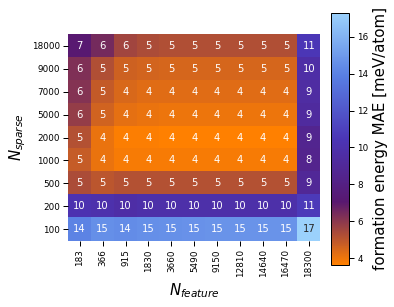

In [43]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
with sns.plotting_context("paper",font_scale=1.,rc={"font.size":10,"axes.titlesize":15,"axes.labelsize":15}):
    g = plot_contour_overlay(data, x='$N_{feature}$', y='$N_{sparse}$', values='formation energy MAE [meV/atom]' , row=None, col=None, **kwargs)
    fname = 'QM9-sparse_vs_feat-rmse_e.png'
    # plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

In [41]:
train_sizes = [500,   1250,   2500,   5000,   7500,  12500,  20000,  25000]
cv = LCSplit(cv=ShuffleSplit, n_repeats=[100, 90, 70, 60, 20, 20, 20, 10],
                             train_sizes=train_sizes, 
                         test_size=0.15, random_state=10)
zetas = [2]
sigmas = {
    # 'qm9_test0':1e-7,
    #   'qm9_30k-rc_3-gs_vdw5-n_12-l_9-norm':1e-5,
    #   'qm9_30k-rc_3-gs_0.3-n_12-l_9-norm':5e-5,
    # 'qm9_30k-standard_soap-all_atom_H-rc_3-gs_0.3-n_12-l_9-norm':5e-5,
    'qm9_30k-rc_3-gs_vdw5-n_12-l_9-norm-rs_1_2_7':1e-3,
    'qm9_30k-rc_3-gs_0.3-n_12-l_9-norm-rs_1_2_7':1e-3
         }

scores = []

# MAE_ref = np.array([6.2011 , 3.5596 , 2.4586 , 1.7491 , 1.4113 , 1.0892 , 0.84063, 0.73578, 0.5082 , 0.36424])
# scores = []
# for n,mae in zip(train_sizes,MAE_ref):
#     scores.append(dict(train_size=n, name='RS ref',MAE=mae))
    
for name,zeta in product(sigmas.keys(), zetas):
    kk = np.load('Kmat-z{}-{}.npy'.format(zeta, name))
    for train, test in tqdm(cv.split(y),leave=False, total=np.sum(cv.n_repeats)):
        score, y_pred, y_t = test_krr(train, test, kk, y, sigmas[name] , jitter=1e-7)
        score = get_score(y_pred/natoms[test]*1000, y_t/natoms[test]*1000)
        score.update(train_size=len(train), name=name)
        scores.append(score)
scores = pd.DataFrame(scores)
scores.to_json('lc_scores-2.json')

In [42]:
# scores.to_json('lc_scores.json')
scores = scores.append(pd.read_json('lc_scores.json'))
scores = scores.append(pd.read_json('lc_scores-1.json'))

In [43]:
scores.groupby(['name','train_size']).mean()

CORR  \
name                                               train_size             
RS ref                                             500              NaN   
                                                   1250             NaN   
                                                   2500             NaN   
                                                   5000             NaN   
                                                   7500             NaN   
                                                   12500            NaN   
                                                   20000            NaN   
                                                   25000            NaN   
qm9_30k-rc_3-gs_0.3-n_12-l_9-norm                  500         0.997249   
                                                   1250        0.998721   
                                                   2500        0.999209   
                                                   5000        0.999433   
                                                   7500        0.999511   
                                                   12500       0.999682   
                                                   20000       0.999721   
                                                   25000       0.999808   
qm9_30k-rc_3-gs_0.3-n_12-l_9-norm-rs_1_2_7         500         0.991190   
                                                   1250        0.996300   
                                                   2500        0.998245   
                                                   5000        0.999161   
                                                   7500        0.999416   
                                                   12500       0.999621   
                                                   20000       0.999721   
                                                   25000       0.999763   
qm9_30k-rc_3-gs_vdw5-n_12-l_9-norm                 500         0.998151   
                                                   1250        0.999074   
                                                   2500        0.999324   
                                                   5000        0.999482   
                                                   7500        0.999563   
                                                   12500       0.999663   
                                                   20000       0.999734   
                                                   25000       0.999749   
qm9_30k-rc_3-gs_vdw5-n_12-l_9-norm-rs_1_2_7        500         0.992996   
                                                   1250        0.997674   
                                                   2500        0.998853   
                                                   5000        0.999411   
                                                   7500        0.999591   
                                                   12500       0.999718   
                                                   20000       0.999780   
                                                   25000       0.999792   
qm9_30k-standard_soap-all_atom_H-rc_3-gs_0.3-n_... 500         0.997545   
                                                   1250        0.998872   
                                                   2500        0.999311   
                                                   5000        0.999529   
                                                   7500        0.999601   
                                                   12500       0.999694   
                                                   20000       0.999735   
                                                   25000       0.999798   
qm9_test0                                          500         0.987133   
                                                   1250        0.993337   
                                                   2500        0.996443   
                                                   5000        0.998302   
                 

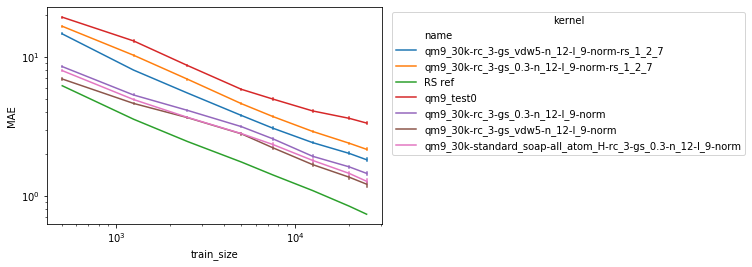

In [44]:
sns.lineplot(data=scores, x='train_size', y='MAE',hue='name', estimator=np.mean,
               dashes=True,markers=True,err_style="bars")
plt.xscale('log')
plt.yscale('log')
plt.legend(title='kernel',loc='upper right', bbox_to_anchor=(2.1, 1))
plt.savefig('lc-qm9.png', dpi=300, bbox_inches='tight')

In [172]:
sns.lineplot?

In [161]:
df = scores.groupby(['name','train_size']).mean()

In [165]:
df.groupby?